In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import tempfile
import pytz
from datetime import datetime
import pyart

templocation = tempfile.mkdtemp()

# Welcome to the iPython nexradaws example

This notebook is designed to show examples using the [nexradaws](http://nexradaws.readthedocs.io/en/latest/index.html) python module.
The first thing we need to do is instantiate an instance of the NexradAwsInterface class. This class contains methods to query and download from the Nexrad Amazon S3 Bucket.

This notebook uses Python 3.6 for it's examples.

In [20]:
import nexradaws
conn = nexradaws.NexradAwsInterface()

### Query methods

Next we will test out some of the available query methods. There are methods to get the available years, months, days, and radars.

#### Get available years

In [21]:
years = conn.get_avail_years()
print(years)

['1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']


#### Get available months in a year

In [22]:
months = conn.get_avail_months('2013')
print(months)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']


#### Get available days in a given year and month

In [23]:
days = conn.get_avail_days('2013','05')
print(days)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


#### Get available radars in a given year, month, and day

In [24]:
radars = conn.get_avail_radars('2013','05','31')
print(radars)

['DAN1', 'KABR', 'KABX', 'KAKQ', 'KAMA', 'KAMX', 'KAPX', 'KARX', 'KATX', 'KBBX', 'KBGM', 'KBHX', 'KBIS', 'KBLX', 'KBMX', 'KBOX', 'KBRO', 'KBUF', 'KBYX', 'KCAE', 'KCBW', 'KCBX', 'KCCX', 'KCLE', 'KCLX', 'KCRP', 'KCXX', 'KCYS', 'KDAX', 'KDDC', 'KDFX', 'KDGX', 'KDLH', 'KDMX', 'KDOX', 'KDTX', 'KDVN', 'KEAX', 'KEMX', 'KENX', 'KEOX', 'KEPZ', 'KESX', 'KEVX', 'KEWX', 'KEYX', 'KFCX', 'KFDR', 'KFFC', 'KFSD', 'KFSX', 'KFTG', 'KFWS', 'KGGW', 'KGJX', 'KGLD', 'KGRB', 'KGRK', 'KGRR', 'KGSP', 'KGWX', 'KGYX', 'KHDX', 'KHGX', 'KHNX', 'KHPX', 'KHTX', 'KICT', 'KICX', 'KILN', 'KILX', 'KIND', 'KINX', 'KIWA', 'KIWX', 'KJAX', 'KJGX', 'KJKL', 'KLBB', 'KLCH', 'KLGX', 'KLIX', 'KLNX', 'KLOT', 'KLRX', 'KLSX', 'KLTX', 'KLVX', 'KLWX', 'KLZK', 'KMAF', 'KMAX', 'KMBX', 'KMHX', 'KMKX', 'KMLB', 'KMOB', 'KMPX', 'KMQT', 'KMRX', 'KMSX', 'KMTX', 'KMUX', 'KMVX', 'KMXX', 'KNKX', 'KNQA', 'KOAX', 'KOHX', 'KOKX', 'KOTX', 'KPAH', 'KPBZ', 'KPDT', 'KPOE', 'KPUX', 'KRAX', 'KRGX', 'KRIW', 'KRLX', 'KRTX', 'KSFX', 'KSGF', 'KSHV', 'KSJT',

## Query for available scans

There are two query methods to get available scans.
* get_avail_scans() - returns all scans for a particular radar on a particular day
* get_avail_scans_in_range() returns all scans for a particular radar between a start and end time

Both methods return a list of [AwsNexradFile](http://nexradaws.readthedocs.io/en/latest/apidocs.html#nexradaws.resources.awsnexradfile.AwsNexradFile) objects that contain metadata about the NEXRAD file on AWS. These objects can then be downloaded by passing them to the download method which we will discuss next.

#### Get all scans for a radar on a given day

In [25]:
availscans = conn.get_avail_scans('2013', '05', '31', 'KTLX')
print("There are {} NEXRAD files available for May 31st, 2013 for the KTLX radar.\n".format(len(availscans)))
print(availscans[0:4])

There are 263 NEXRAD files available for May 31st, 2013 for the KTLX radar.

[<AwsNexradFile object - 2013/05/31/KTLX/KTLX20130531_000358_V06.gz>, <AwsNexradFile object - 2013/05/31/KTLX/KTLX20130531_000834_V06.gz>, <AwsNexradFile object - 2013/05/31/KTLX/KTLX20130531_001311_V06.gz>, <AwsNexradFile object - 2013/05/31/KTLX/KTLX20130531_001747_V06.gz>]


#### Get all scans for a radar between a start and end time

Now let's get all available scans between 5-7pm CST May 31, 2013 which is during the El Reno, OK tornado. The get_avail_scans_in_range method accepts datetime objects for the start and end time. 

If the passed datetime objects are timezone aware then it will convert them to UTC before query. If they are not timezone aware it will assume the passed datetime is in UTC.

In [26]:
central_timezone = pytz.timezone('US/Central')
radar_id = 'KTLX'
start = central_timezone.localize(datetime(2013,5,31,17,0))
end = central_timezone.localize (datetime(2013,5,31,19,0))
scans = conn.get_avail_scans_in_range(start, end, radar_id)
print("There are {} scans available between {} and {}\n".format(len(scans), start, end))
print(scans[0:4])

There are 26 scans available between 2013-05-31 17:00:00-05:00 and 2013-05-31 19:00:00-05:00

[<AwsNexradFile object - 2013/05/31/KTLX/KTLX20130531_220114_V06.gz>, <AwsNexradFile object - 2013/05/31/KTLX/KTLX20130531_220537_V06.gz>, <AwsNexradFile object - 2013/05/31/KTLX/KTLX20130531_221011_V06.gz>, <AwsNexradFile object - 2013/05/31/KTLX/KTLX20130531_221445_V06.gz>]


## Downloading Files

Now let's download some radar files from our previous example. Let's download the first 4 scans from our query above.

In [27]:
results = conn.download(scans[0:4], templocation)

Downloaded KTLX20130531_220537_V06.gz
Downloaded KTLX20130531_221445_V06.gz
Downloaded KTLX20130531_220114_V06.gz
Downloaded KTLX20130531_221011_V06.gz
4 out of 4 files downloaded...0 errors


The download method returns a [DownloadResult](http://nexradaws.readthedocs.io/en/latest/apidocs.html#nexradaws.resources.downloadresults.DownloadResults) object. The success attribute returns a list of [LocalNexradFile](http://nexradaws.readthedocs.io/en/latest/apidocs.html#nexradaws.resources.localnexradfile.LocalNexradFile) objects that were successfully downloaded. There is also an iter_success method that creates a generator for easily looping through the objects.

In [28]:
print(results.success)

[<LocalNexradFile object - C:\Users\AARON~1.AND\AppData\Local\Temp\5\tmpdu8e2bwz\KTLX20130531_220114_V06.gz>, <LocalNexradFile object - C:\Users\AARON~1.AND\AppData\Local\Temp\5\tmpdu8e2bwz\KTLX20130531_220537_V06.gz>, <LocalNexradFile object - C:\Users\AARON~1.AND\AppData\Local\Temp\5\tmpdu8e2bwz\KTLX20130531_221011_V06.gz>, <LocalNexradFile object - C:\Users\AARON~1.AND\AppData\Local\Temp\5\tmpdu8e2bwz\KTLX20130531_221445_V06.gz>]


In [29]:
for scan in results.iter_success():
    print ("{} volume scan time {}".format(scan.radar_id,scan.scan_time))

KTLX volume scan time 2013-05-31 22:01:14+00:00
KTLX volume scan time 2013-05-31 22:05:37+00:00
KTLX volume scan time 2013-05-31 22:10:11+00:00
KTLX volume scan time 2013-05-31 22:14:45+00:00


You can check for any failed downloads using the failed_count attribute. You can get a list of the failed [AwsNexradFile](http://nexradaws.readthedocs.io/en/latest/apidocs.html#nexradaws.resources.awsnexradfile.AwsNexradFile) objects by calling the failed attribute. There is also a generator method called iter_failed that can be used to loop through the failed objects.

In [30]:
print("{} downloads failed.".format(results.failed_count))

0 downloads failed.


In [31]:
print(results.failed)

[]


## Working with LocalNexradFile objects

Now that we have downloaded some files let's take a look at what is available with the [LocalNexradFile](http://nexradaws.readthedocs.io/en/latest/apidocs.html#nexradaws.resources.localnexradfile.LocalNexradFile) objects.

These objects have attributes containing metadata about the local file including local filepath, last_modified (on AWS), filename, volume scan time, and radar id.

There are two methods available on the LocalNexradFile to open the local file.
* open() - returns a file object. Be sure to close the file object when done.
* open_pyart() - if pyart is installed this will return a pyart Radar object.

Let's look at an example of using pyart to open and plot our newly downloaded NEXRAD file from AWS. We will zoom into within 150km of the radar to see the storms a little better in these examples.

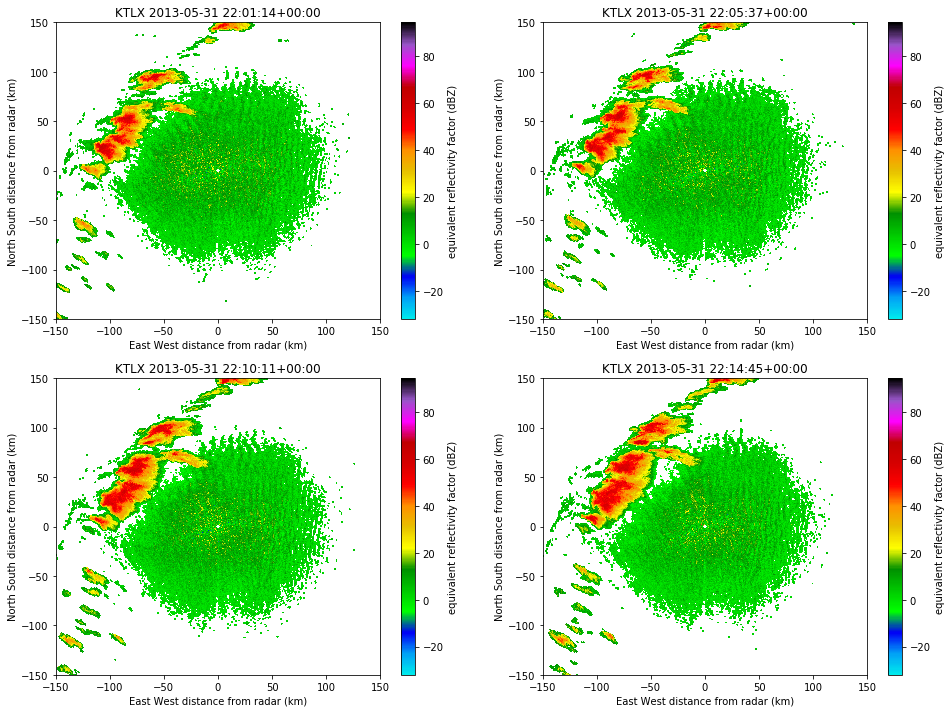

In [32]:
fig = plt.figure(figsize=(16,12))
for i,scan in enumerate(results.iter_success(),start=1):
    ax = fig.add_subplot(2,2,i)
    radar = scan.open_pyart()
    display = pyart.graph.RadarDisplay(radar)
    display.plot('reflectivity',0,ax=ax,title="{} {}".format(scan.radar_id,scan.scan_time))
    display.set_limits((-150, 150), (-150, 150), ax=ax)

Now lets plot velocity data for the same scans.

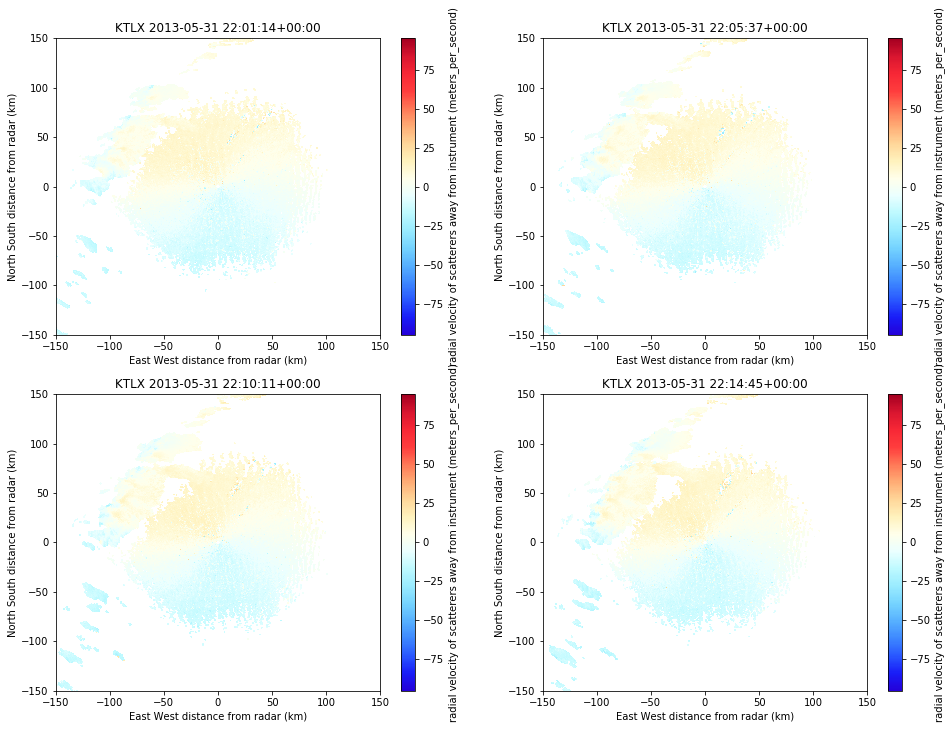

In [33]:
fig = plt.figure(figsize=(16,12))
for i,scan in enumerate(results.iter_success(),start=1):
    ax = fig.add_subplot(2,2,i)
    radar = scan.open_pyart()
    display = pyart.graph.RadarDisplay(radar)
    display.plot('velocity',1,ax=ax,title="{} {}".format(scan.radar_id,scan.scan_time))
    display.set_limits((-150, 150), (-150, 150), ax=ax)